<a href="https://colab.research.google.com/github/prashanth018/Text-Summarization/blob/shreya/Copy_of_NLP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import io
import re
import spacy
from time import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import os

#strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
#print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

In [2]:
from google.colab import files
uploaded = files.upload()

Saving News_Category_Dataset-17000-30000.csv to News_Category_Dataset-17000-30000.csv


In [3]:
dataset = pd.read_csv(io.BytesIO(uploaded[r'News_Category_Dataset-17000-30000.csv']))
dataset

,Unnamed: 0,news_text,category,headline,short_desc,url
0,1,andyshots via Getty Images #TitheTrans invites...,QUEER VOICES,Christian LGBTQ Group Raises Money To Help Pay...,“I want #TitheTrans to be a way for Christians...,https://www.huffingtonpost.com/entry/christian...
1,2,Today’s topics include: Comedian Jen Kirkman i...,COMEDY,The Bob Cesca Show Podcast: Comedian Jen Kirkm...,Today’s topics include: Comedian Jen Kirkman i...,https://www.huffingtonpost.com/entry/the-bob-c...
2,3,Congress has returned to Washington after a mo...,POLITICS,A Big To-Do List For Congress,Congress has returned to Washington after a mo...,https://www.huffingtonpost.com/entry/a-big-to-...
3,4,"Like most teachers, I’ve worked at a variety o...",EDUCATION,Every Teacher Should Be Bad At Something,Many of our students have to get up every day ...,https://www.huffingtonpost.com/entry/every-tea...
4,5,Welcome to the horrible world of the news.\n\n...,WORLD NEWS,"News Roundup for September 7, 2017",Welcome to the horrible world of the news. 1. ...,https://www.huffingtonpost.com/entry/news-roun...
...,...,...,...,...,...,...
4895,4896,AP/The Flint Journal-MLive.com/Jake May The ch...,EDUCATION,"The Charter School Charade Offers Rhetoric, No...",Charter school advocates are well-versed in th...,https://www.huffingtonpost.com/entry/the-chart...
4896,4897,An abiding image of Simone Veil from September...,WORLD NEWS,Two Or Three Things I Know About Simone Veil,She was both imperious and gentle. Irascible a...,https://www.huffingtonpost.com/entry/two-or-th...
4897,4898,Nobody has ever accused Donald Trump of being ...,POLITICS,Trump Accidentally Confirms Lavrov Account Of ...,Trump’s Sunday morning tweet is more consisten...,https://www.huffingtonpost.com/entry/trump-acc...
4898,4899,"By Elizabeth Mormino, PhD, Stanford University...",HEALTHY LIVING,To Understand Sex Differences In Alzheimer’s D...,"By Elizabeth Mormino, PhD, Stanford University...",https://www.huffingtonpost.com/entry/to-unders...


In [4]:
df = pd.DataFrame()
df['news_text'] = dataset['news_text']
df['headline'] = dataset['headline']
df

,news_text,headline
0,andyshots via Getty Images #TitheTrans invites...,Christian LGBTQ Group Raises Money To Help Pay...
1,Today’s topics include: Comedian Jen Kirkman i...,The Bob Cesca Show Podcast: Comedian Jen Kirkm...
2,Congress has returned to Washington after a mo...,A Big To-Do List For Congress
3,"Like most teachers, I’ve worked at a variety o...",Every Teacher Should Be Bad At Something
4,Welcome to the horrible world of the news.\n\n...,"News Roundup for September 7, 2017"
...,...,...
4895,AP/The Flint Journal-MLive.com/Jake May The ch...,"The Charter School Charade Offers Rhetoric, No..."
4896,An abiding image of Simone Veil from September...,Two Or Three Things I Know About Simone Veil
4897,Nobody has ever accused Donald Trump of being ...,Trump Accidentally Confirms Lavrov Account Of ...
4898,"By Elizabeth Mormino, PhD, Stanford University...",To Understand Sex Differences In Alzheimer’s D...


In [5]:
def text_strip(column):

    for row in column:
        row = re.sub("(\\t)", " ", str(row)).lower()
        row = re.sub("(\\r)", " ", str(row)).lower()
        row = re.sub("(\\n)", " ", str(row)).lower()

        # Remove _ if it occurs more than one time consecutively
        row = re.sub("(__+)", " ", str(row)).lower()

        # Remove - if it occurs more than one time consecutively
        row = re.sub("(--+)", " ", str(row)).lower()

        # Remove ~ if it occurs more than one time consecutively
        row = re.sub("(~~+)", " ", str(row)).lower()

        # Remove + if it occurs more than one time consecutively
        row = re.sub("(\+\++)", " ", str(row)).lower()

        # Remove . if it occurs more than one time consecutively
        row = re.sub("(\.\.+)", " ", str(row)).lower()

        # Remove the characters - <>()|&©ø"',;?~*!
        row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(row)).lower()

        # Remove mailto:
        row = re.sub("(mailto:)", " ", str(row)).lower()

        # Remove \x9* in text
        row = re.sub(r"(\\x9\d)", " ", str(row)).lower()

        # Replace INC nums to INC_NUM
        row = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(row)).lower()

        # Replace CM# and CHG# to CM_NUM
        row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(row)).lower()

        # Remove punctuations at the end of a word
        row = re.sub("(\.\s+)", " ", str(row)).lower()
        row = re.sub("(\-\s+)", " ", str(row)).lower()
        row = re.sub("(\:\s+)", " ", str(row)).lower()

        # Replace any url to only the domain name
        try:
            url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(row))
            repl_url = url.group(3)
            row = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(row))
        except:
            pass

        # Remove multiple spaces
        row = re.sub("(\s+)", " ", str(row)).lower()

        # Remove the single character hanging between any two spaces
        row = re.sub("(\s+.\s+)", " ", str(row)).lower()

        yield row

In [6]:
processed_text = text_strip(df['news_text'])
processed_summary = text_strip(df['headline'])
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
text = [str(doc) for doc in nlp.pipe(processed_text, batch_size=2000)]
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(processed_summary, batch_size=2000)]

In [7]:
df['cleaned_news_text'] = pd.Series(text)
df['cleaned_headline'] = pd.Series(summary)

In [8]:
df

,news_text,headline,cleaned_news_text,cleaned_headline
0,andyshots via Getty Images #TitheTrans invites...,Christian LGBTQ Group Raises Money To Help Pay...,andyshots via getty images #tithetrans invites...,_START_ christian lgbtq group raises money to ...
1,Today’s topics include: Comedian Jen Kirkman i...,The Bob Cesca Show Podcast: Comedian Jen Kirkm...,today’s topics include comedian jen kirkman is...,_START_ the bob cesca show podcast comedian je...
2,Congress has returned to Washington after a mo...,A Big To-Do List For Congress,congress has returned to washington after mont...,_START_ a big to-do list for congress _END_
3,"Like most teachers, I’ve worked at a variety o...",Every Teacher Should Be Bad At Something,like most teachers i’ve worked at variety of s...,_START_ every teacher should be bad at somethi...
4,Welcome to the horrible world of the news.\n\n...,"News Roundup for September 7, 2017",welcome to the horrible world of the news hurr...,_START_ news roundup for september 2017 _END_
...,...,...,...,...
4895,AP/The Flint Journal-MLive.com/Jake May The ch...,"The Charter School Charade Offers Rhetoric, No...",ap/the flint journal-mlive.com/jake may the ch...,_START_ the charter school charade offers rhet...
4896,An abiding image of Simone Veil from September...,Two Or Three Things I Know About Simone Veil,an abiding image of simone veil from september...,_START_ two or three things know about simone ...
4897,Nobody has ever accused Donald Trump of being ...,Trump Accidentally Confirms Lavrov Account Of ...,nobody has ever accused donald trump of being ...,_START_ trump accidentally confirms lavrov acc...
4898,"By Elizabeth Mormino, PhD, Stanford University...",To Understand Sex Differences In Alzheimer’s D...,by elizabeth mormino phd stanford university s...,_START_ to understand sex differences in alzhe...


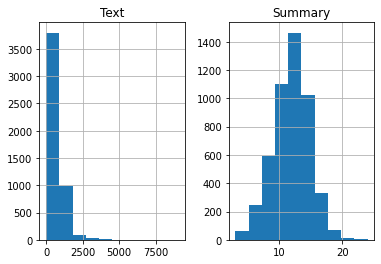

In [9]:
text_count = []
summary_count = []
for sent in df['cleaned_news_text']:
  text_count.append(len(sent.split()))
for sent in df['cleaned_headline']:
  summary_count.append(len(sent.split()))
graph = pd.DataFrame()
graph['Text'] = text_count
graph['Summary'] = summary_count
graph.hist(bins=10)
plt.show()

In [10]:
cnt = 0
for sent in df['cleaned_news_text']:
  if len(sent.split())<=1500:
    cnt=cnt+1
print(cnt/len(df['cleaned_news_text']))

0.9477551020408164


In [11]:
max_text_len = 2500
max_summary_len = 20

In [12]:
cleaned_text = np.array(df['cleaned_news_text'])
cleaned_summary= np.array(df['cleaned_headline'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre = pd.DataFrame({'text': short_text,'summary': short_summary})

post_pre.head(2)

,text,summary
0,andyshots via getty images #tithetrans invites...,_START_ christian lgbtq group raises money to ...
1,today’s topics include comedian jen kirkman is...,_START_ the bob cesca show podcast comedian je...


In [13]:
post_pre['summary'] = post_pre['summary'].apply(lambda x: 'sostok ' + x \
        + ' eostok')

post_pre.head(2)

,text,summary
0,andyshots via getty images #tithetrans invites...,sostok _START_ christian lgbtq group raises mo...
1,today’s topics include comedian jen kirkman is...,sostok _START_ the bob cesca show podcast come...


In [14]:
x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(post_pre["text"]),
    np.array(post_pre["summary"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

In [15]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

% of rare words in vocabulary:  68.6314993994845


In [16]:
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 23246


In [17]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 5

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 81.90920468767779
Size of vocabulary in Y = 1591


In [18]:
ind = []

for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [19]:
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

In [20]:

latent_dim = 120
embedding_dim = 70

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

  # Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

  # Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

#  Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2500)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 2500, 70)     1627220     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 2500, 120),  91680       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [21]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [22]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=40,
    callbacks=[es],
    batch_size=128,
    validation_data=([x_val, y_val[:, :-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]),)

Epoch 1/40
35/35 [==============================] - 832s 23s/step - loss: 5.2858 - val_loss: 3.1680
Epoch 2/40
35/35 [==============================] - 825s 24s/step - loss: 3.1570 - val_loss: 2.8901
Epoch 3/40
35/35 [==============================] - 821s 23s/step - loss: 2.8756 - val_loss: 2.6787
Epoch 4/40
35/35 [==============================] - 814s 23s/step - loss: 2.7279 - val_loss: 2.6455
Epoch 5/40
35/35 [==============================] - 817s 23s/step - loss: 2.6525 - val_loss: 2.5520
Epoch 6/40
35/35 [==============================] - 812s 23s/step - loss: 2.6334 - val_loss: 2.5405
Epoch 7/40
35/35 [==============================] - 809s 23s/step - loss: 2.6082 - val_loss: 2.5198
Epoch 8/40
35/35 [==============================] - 805s 23s/step - loss: 2.5977 - val_loss: 2.5100
Epoch 9/40
35/35 [==============================] - 805s 23s/step - loss: 2.5751 - val_loss: 2.5042
Epoch 10/40
35/35 [==============================] - 806s 23s/step - loss: 2.5552 - val_loss: 2.4986

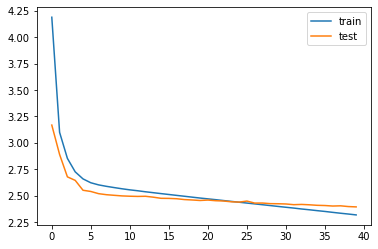

In [23]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [24]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [25]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [26]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [27]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

In [28]:
for i in range(0, 19):
    print ('Review:', seq2text(x_tr[i]))
    print ('Original summary:', seq2summary(y_tr[i]))
    print ('Predicted summary:', decode_sequence(x_tr[i].reshape(1, max_text_len)))
    print ('\n')

Review: cardinal timothy dolan of new york charged tuesday that president trump’s termination of the daca program “is certainly not christian and would contend it’s not american ” ending the program to help immigrants who came to the u s as children he said on the radio program with cardinal dolan our beloved immigrants into political hockey and they shouldn’t be ” dolan noted trump’s oft expressed concern that immigrants can bring crime with them but suggested that fear is overblown “the statistics show that way less than one percent of the immigrants are criminals are drug carriers are terrorists said dolan less than one percent ” “and to protect the borders from them bravo is that ever essential for sound and fair government “but to penalize all these wonderful people on the program he also talked with cardinal joseph from the archdiocese of newark who called trump’s announcement “another act of bullying ” dolan noted cardinal assertion that “you’re talking about kids who are fleein